# COMP 4437 Artificial Neural Networks, Spring’24 Homework 1
## 1. Standard normalization by vectorization.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
def stdnorm(X):
    """
    Inputs:
    - X: A numpy array of shape (N, D)
    Returns:
    A numpy array of shape (N, D) where Y[i] contains the same data as X[i],
    but normalized to have zero mean and unit standard deviation.
    Hint: Use the axis argument for calculations along the correct axis.
    Use the keepdims argument to be able to do broadcasting.
    """
    
    # FILL HERE: one-line long code only, for part (b) 
    return  (X-np.mean(X, axis=0, keepdims=True))/np.std(X, axis=0, keepdims=True)
N = 10
D = 3
# x_org = np.arange(1, N+1).reshape(N,1) @ np.arange(1, D+1).reshape(1,D)
x_org = np.arange(1, N+1)[:, np.newaxis] * np.arange(1, D+1)
print(x_org.shape)
print(x_org)
x_norm = stdnorm(x_org)
print(x_norm)
print('Mean:', np.mean(x_norm, axis=0))
print('Std:', np.std(x_norm, axis=0))

(10, 3)
[[ 1  2  3]
 [ 2  4  6]
 [ 3  6  9]
 [ 4  8 12]
 [ 5 10 15]
 [ 6 12 18]
 [ 7 14 21]
 [ 8 16 24]
 [ 9 18 27]
 [10 20 30]]
[[-1.5666989  -1.5666989  -1.5666989 ]
 [-1.21854359 -1.21854359 -1.21854359]
 [-0.87038828 -0.87038828 -0.87038828]
 [-0.52223297 -0.52223297 -0.52223297]
 [-0.17407766 -0.17407766 -0.17407766]
 [ 0.17407766  0.17407766  0.17407766]
 [ 0.52223297  0.52223297  0.52223297]
 [ 0.87038828  0.87038828  0.87038828]
 [ 1.21854359  1.21854359  1.21854359]
 [ 1.5666989   1.5666989   1.5666989 ]]
Mean: [-1.11022302e-16 -1.11022302e-16 -1.11022302e-16]
Std: [1. 1. 1.]


## 2. The XOR problem

In [3]:

# Create XOR dataset
X_e = np.array([[0, 0],
                [0, 1],
                [1, 0],
                [1, 1]])
y_e = np.array([[0], [1], [1], [0]])


In [74]:
class XORNeuralNetwork:
    def init(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.biases_hidden = np.random.randn(1, hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.random.randn(1, output_size)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.sigmoid(hidden_layer_input)
        output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        output = self.sigmoid(output_layer_input)
        return output

    def train(self, X, y, learning_rate=0.1, epochs=10000):
        for epoch in range(epochs):
            output = self.forward(X)

            error = y - output
            d_output = error * output * (1 - output)
            error_hidden = d_output.dot(self.weights_hidden_output.T)
            d_hidden = error_hidden * self.hidden_layer_output * (1 - self.hidden_layer_output)

            self.weights_hidden_output += self.hidden_layer_output.T.dot(d_output) * learning_rate
            self.bias_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate
            self.weights_input_hidden += X.T.dot(d_hidden) * learning_rate
            self.biases_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    def predict(self, X):
        return np.round(self.forward(X))



            
        



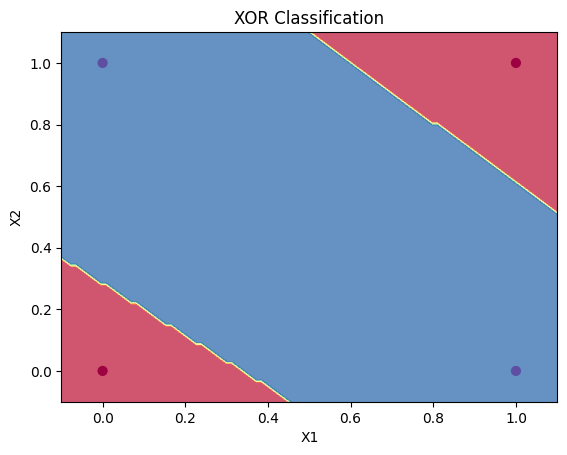

In [110]:

# Train the XOR model
model = XORNeuralNetwork()
model.init(2, 2, 1)
model.train(X_e, y_e)

def plotdecision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('XOR Classification')


plotdecision_boundary(model, X_e, y_e)
plt.show()




# Q3

## Part (a): Implementation of the Method
In this part, I am implementing logistic regression using a two-layer neural network with sigmoid activation functions at both the hidden and output layers. We use mean squared error (MSE) loss and L2 regularization. Stochastic gradient descent with momentum is employed for optimization. The implementation is done using only the NumPy package.

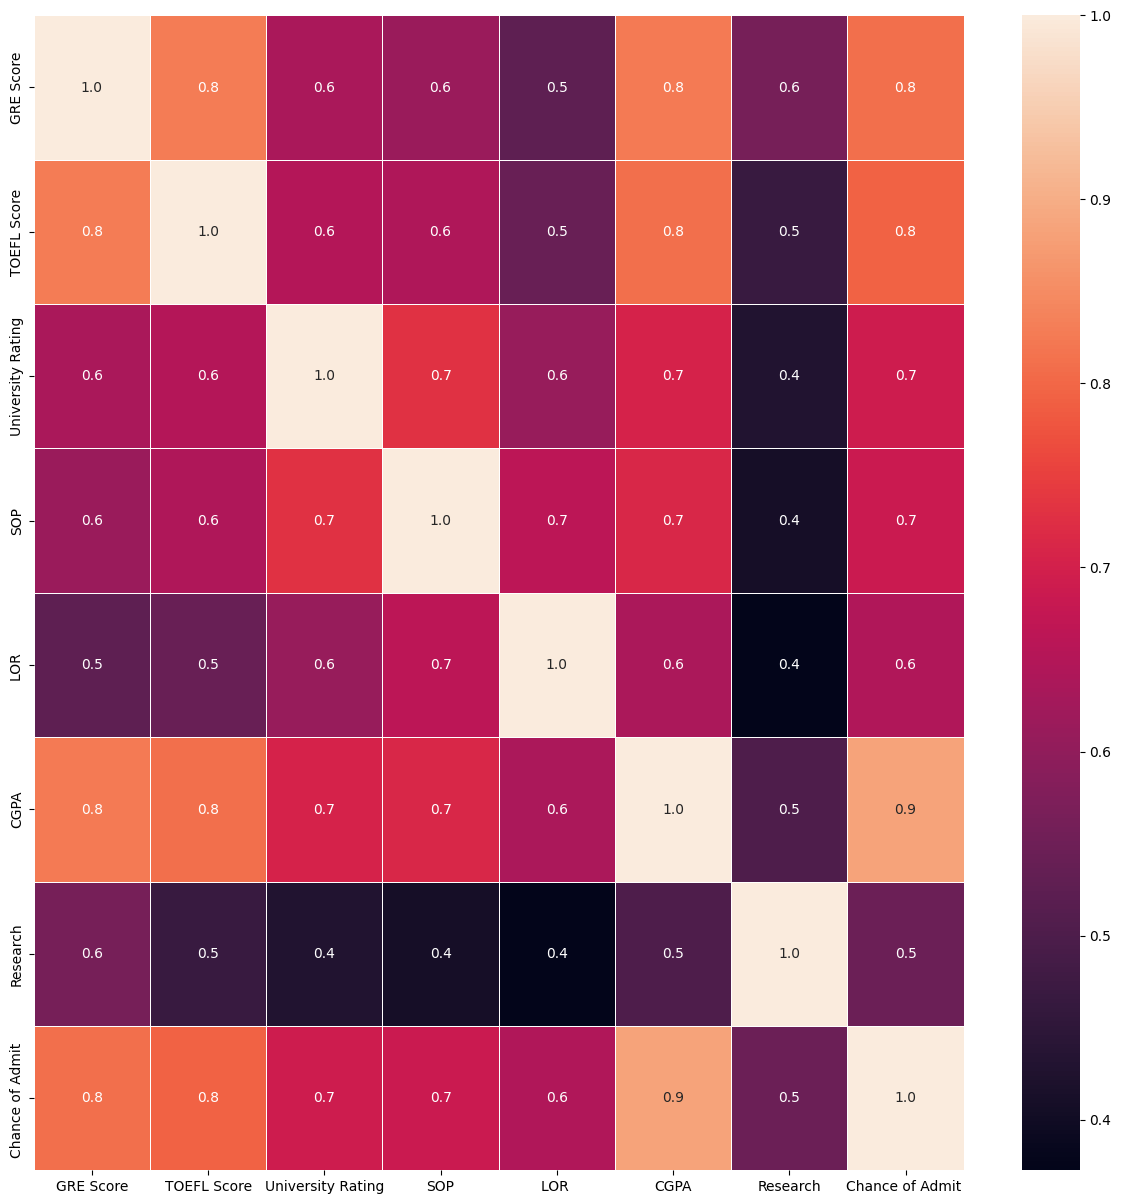

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Read the dataset
dataset = pd.read_csv('admissionv2.csv')
# Explore the dataset
# Observe that the scales and centers are very different which needs to be fixed,
# and the column "Serial No." is actually just the row number so it must be removed.
dataset # To print the dataset (In a jupyter notebook there is no need to use the print command)
dataset.head(10) # Or, you can print only the first 10 lines
dataset.describe() # The basic statistical description of the dataset
# Remove the useless "Serial No."
dataset.drop('Serial No.', axis=1, inplace=True)
# Let's look at the correlations across the columns.
dataset.corr() # Print the correlations
# We can see easier when we draw a correlation heatmap
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(dataset.corr(), annot=True, linewidths=0.5, linecolor="white", fmt= '.1f',ax=ax)
plt.show()

In [7]:
# Let's prepare the dataset for the experimentation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Separate the targets from the inputs
X = dataset.iloc[:,:-1].values
Y = dataset.iloc[:,7].values.reshape(-1,1) # Chance of admission
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
# Split the training and validation sets (ensuring the same split always)
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30,
shuffle=False, random_state=1)
# Preprocessing (by standard normalization since we observed quite different scales/centers)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train) # We fit the scaler only on the training set
x_valid = scaler.transform(x_valid) # We use the resulting fit on the validation set (always!)
print(x_train.shape, x_valid.shape)

def batch_generator(X, Y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    if shuffle:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        yield (X[start_idx:end_idx], Y[start_idx:end_idx])

(350, 7) (150, 7)


In [8]:
# Implementing the Logistic Regression
class TwoLayerMLP:
    def __init__(self, input_size, hidden_size, output_size, reg_lambda,rho=0.9):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.reg_lambda = reg_lambda
        self.rho=rho
        self.init_weights()
        self.zero_grad()

    def init_weights(self):
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))
        self.velocity_W1 = np.zeros_like(self.W1)
        self.velocity_W2 = np.zeros_like(self.W2)
        self.velocity_b1 = np.zeros_like(self.b1)
        self.velocity_b2 = np.zeros_like(self.b2)


    def zero_grad(self):
        self.dW1 = np.zeros_like(self.W1)
        self.db1 = np.zeros_like(self.b1)
        self.dW2 = np.zeros_like(self.W2)
        self.db2 = np.zeros_like(self.b2)


    def update_weights(self, learning_rate):
        self.velocity_W1 = self.velocity_W1 * self.rho  + self.dW1
        self.W1 -= learning_rate * self.velocity_W1
        self.velocity_b1 = self.velocity_b1 * self.rho + self.db1
        self.b1 -= learning_rate * self.velocity_b1
        self.velocity_W2 = self.velocity_W2 * self.rho + self.dW2
        self.W2 -= learning_rate * self.velocity_W2
        self.velocity_b2 = self.velocity_b2 * self.rho + self.db2
        self.b2 -= learning_rate * self.velocity_b2

      

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z):
        s = self.sigmoid(Z)
        return s * (1 - s)

    def forward(self, X, Y=None):
        self.X = X
        if Y is not None:
            self.Y = Y
            
        
        self.Z1=self.sigmoid(np.dot(X,self.W1)+self.b1)
        self.H1=self.Z1
        self.Z2=self.sigmoid(np.dot(self.Z1,self.W2)+self.b2)
        self.H2=self.Z2
        
        return self.H2

    def compute_loss(self, Y_pred=None, Y=None):
        if Y_pred is None:
            Y_pred = self.H2  
        if Y is None:
            Y = self.Y

            
        batch_size = Y.shape[0]
        data_loss = np.sum((Y_pred - Y) ** 2) / batch_size
        reg_loss = (self.reg_lambda / 2) *np.sum(np.square(self.W1)+np.sum(np.square(self.W2))) / batch_size
        loss = data_loss + reg_loss
        return loss
    

    def backward(self, X, Y):
        Y_pred = self.H2 
        Y = self.Y
        X = self.X
        batch_size = Y.shape[0]

        dZ2 = (Y_pred - Y) * self.sigmoid_derivative(self.Z2)
        self.dW2 = (np.dot(self.H1.T, dZ2) + self.reg_lambda * self.W2) / batch_size
        self.db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size

        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(self.Z1)
        self.dW1 = (np.dot(X.T, dZ1) + self.reg_lambda * self.W1) / batch_size
        self.db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size

    def train(self, X, y, batch_size, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            for X_batch, y_batch in batch_generator(X, y, batch_size):
                self.forward(X_batch, y_batch)
                self.backward()
                self.update_weights(learning_rate)
            if epoch % 100 == 0:
                loss = self.compute_loss()
                print(f'Epoch {epoch}, loss {loss}')

    def predict(self, X):
        return self.forward(X)
    
        

In [9]:

class SGD:
    def __init__(self, model, learning_rate, batch_size):
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
     
    def step(self):
        self.model.update_weights(self.learning_rate)
        
    def zero_grad(self):
        self.model.zero_grad()

    def train_sgd(model, optimizer, X_train, Y_train, epochs, batch_size):
        loss_list = []
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            total_loss = 0
            indices = np.random.permutation(n_samples)

            for i in range(0, n_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                X_batch = X_train[batch_indices]
                Y_batch = Y_train[batch_indices]

                model.forward(X_batch, Y_batch)  
                loss = model.compute_loss()  
                model.backward(X_batch, Y_batch)
                optimizer.step()
                optimizer.zero_grad()
                total_loss += loss

            avg_loss = total_loss / (n_samples / batch_size)
            loss_list.append(avg_loss)
                
        return loss_list




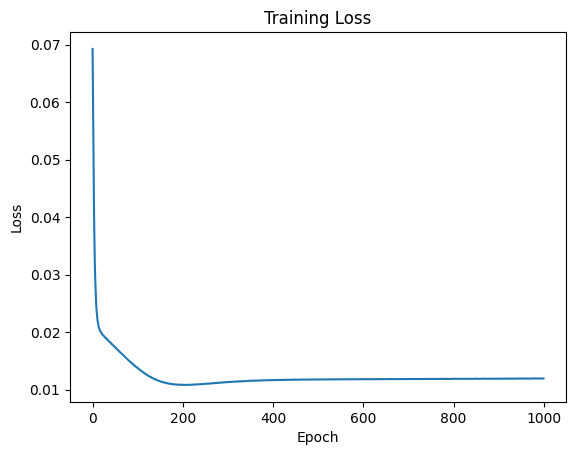

In [10]:
model = TwoLayerMLP(input_size=7, hidden_size=5, output_size=1, reg_lambda=0.01)
optimizer = SGD(model, learning_rate=0.01, batch_size=32)
loss_list = SGD.train_sgd(model, optimizer, x_train, y_train, epochs=1000, batch_size=32)
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()




## Part (b): Explanation of Performance Metrics
Two performance metrics used for evaluating the model: R2 score and root-mean-square error (RMSE).

R2 Score: It measures the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 score ranges from -∞ to 1, where 1 indicates a perfect fit and values close to 0 or negative indicate poor performance.
RMSE: It measures the average magnitude of the residuals between predicted and actual values. RMSE ranges from 0 to +∞, where 0 indicates a perfect fit and higher values indicate poorer performance.

R^2 score: 0.8253920718918474
RMSE: 0.05967272891707999


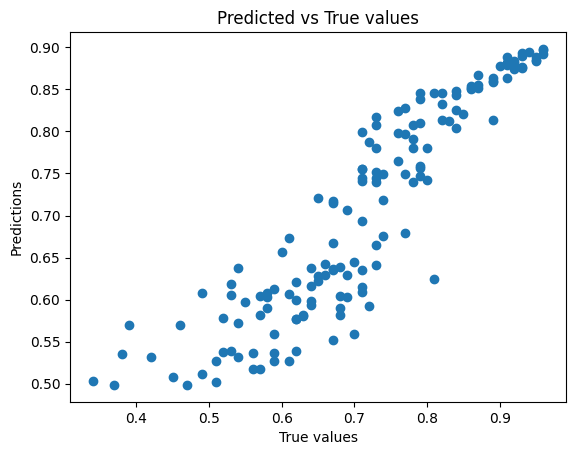

In [11]:
from sklearn.metrics import r2_score, root_mean_squared_error
y_pred = model.predict(x_valid)

# Calculate the R^2 score
r2 = r2_score(y_valid, y_pred)
print('R^2 score:', r2)

# Calculate the RMSE
rmse = root_mean_squared_error(y_valid, y_pred)
print('RMSE:', rmse)

# Plot the predicted vs true values
plt.scatter(y_valid, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predicted vs True values')
plt.show()

## Part (c): Hyperparameter Tuning via Grid Search
In this part, I perform hyperparameter tuning using grid search. I explored different combinations of hyperparameters such as layer size, learning rate, batch size, regularization strength, and momentum coefficient. For each combination, I trained the model on the training set and evaluate its performance on the validation set using R2 score. I selected the combination of hyperparameters that yields the highest R2 score as the best model. Finally, I reported the best hyperparameters and the corresponding R2 score.

Best hyperparameters: hidden_size=20, reg_lambda=0.01, learning_rate=1.0, batch_size=32
Best R^2: 0.8530328555629796
Best RMSE: 0.05474620857011989


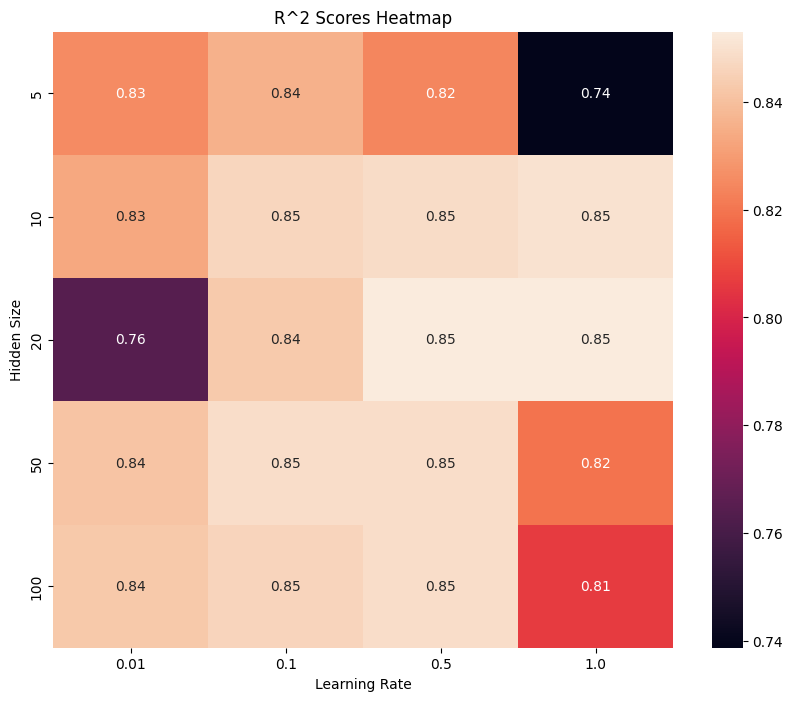

In [12]:
import seaborn as sns

# Initialize lists to store hyperparameters and corresponding scores
hidden_sizes = [5, 10, 20, 50, 100]
reg_lambdas = [0.01, 0.1]
learning_rates = [0.01, 0.1, 0.5, 1.0]
batch_sizes = [32, 64, 128]

r2_scores = np.zeros((len(hidden_sizes), len(learning_rates)))
rmse_scores = np.zeros((len(hidden_sizes), len(learning_rates)))

best_r2 = -np.inf
best_rmse = np.inf
best_params = None

# Hyperparameter tuning with grid search
for i, hidden_size in enumerate(hidden_sizes):
    for j, learning_rate in enumerate(learning_rates):
        for reg_lambda in reg_lambdas:
            for batch_size in batch_sizes:
                model = TwoLayerMLP(input_size=7, hidden_size=hidden_size, output_size=1, reg_lambda=reg_lambda)
                optimizer = SGD(model, learning_rate=learning_rate, batch_size=batch_size)
                loss_list = SGD.train_sgd(model, optimizer, x_train, y_train, epochs=1000, batch_size=batch_size)
                y_pred = model.predict(x_valid)
                r2 = r2_score(y_valid, y_pred)
                rmse = root_mean_squared_error(y_valid, y_pred)
                #print(f'hidden_size={hidden_size}, reg_lambda={reg_lambda}, learning_rate={learning_rate}, batch_size={batch_size}, R^2={r2}, RMSE={rmse}')
                
                # Update best scores and parameters
                if r2 > best_r2:
                    best_r2 = r2
                    best_rmse = rmse
                    best_params = (hidden_size, reg_lambda, learning_rate, batch_size)
                
                # Update scores for heatmap
                if reg_lambda == best_params[1] and batch_size == best_params[3]:
                    r2_scores[i, j] = r2
                    rmse_scores[i, j] = rmse

print(f'Best hyperparameters: hidden_size={best_params[0]}, reg_lambda={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}')
print(f'Best R^2: {best_r2}')
print(f'Best RMSE: {best_rmse}')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(r2_scores, annot=True, xticklabels=learning_rates, yticklabels=hidden_sizes)
plt.xlabel('Learning Rate')
plt.ylabel('Hidden Size')
plt.title('R^2 Scores Heatmap')
plt.show()



# References
- Our labworks
- [Michigan Online](https://www.youtube.com/watch?v=dJYGatp4SvA&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r)
- Colleuges: Bartu Çatal, Efe İlhan
- AI Tools
- [Sebastian Lauge](https://www.youtube.com/watch?v=hfMk-kjRv4c)